<a href="https://colab.research.google.com/github/SPlearning27/DDDS-My-Projects/blob/main/Capstone-Project/%20Capstone_Project_EVregistration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of EV Charging station installed in ABQ, NM

## Project Problems




Q1) How many EV cars are per zip code?

Q2) What type of drive chain is the most population based on the existing types between battery electric vehicle (BEV) versus plug-in hybrid electric vehicle (PHEV)?

Note:
We can add more questions based on the data we can find.

## Let's explore the data
From the existing data, we can predict:

- Total Number of EVs per ZIP Code in New Mexico: This is the most direct and crucial piece of information.
  - Knowing which zip codes have a higher concentration of EVs helps in strategically placing charging stations.

- Characteristics of the EV Fleet per ZIP Code: By aggregating features like the average EV model year, or the number of unique EV makes/models.
  - To get a sense of the maturity and diversity of the EV market in a given area.
  - For example, a high average model year might indicate a newer, growing EV population.

- Potential for EV Growth (indirectly): While the current snapshot doesn't directly show growth over time, the presence of newer model year EVs or a high number of unique EV models in a zipcode can indirectly suggest a more active and growing EV market.
  - To truly predict growth, historical data (multiple snapshots over time) would be ideal, allowing for time-series analysis or features like "rate of new EV registrations."
  - The column 'DMV Snapshot ID' provides unique identifier to distinguish DMV snapshots. Index aggregations by this field to create longitudinal data summaries.

## Direction for data processing

To make more beneficial for an EV charging station business, here can be the project focuses (based on the data we have):

1.   Isolate Electric Vehicles: It filters for Drivetrain Type being 'BEV' (Battery Electric Vehicle) or 'PHEV' (Plug-in Hybrid Electric Vehicle).
2.   Predict Total EVs: The machine learning model is now trained to predict the Total EVs per zipcode.
3.  Use EV-Specific Features: The predictive features are now derived from the EV data (e.g., average EV model year, number of unique EV makes/models).


## Expected Outcomes

- We can use the data outcomes from this data processing to taking into consideration the marker growth-driving factors:
  - To answer where we can locate new EV charging stations.
  - what type of chargers should be installed more in the new charging stations for customers' convenience.
  - how can we improve the charging speed of the charger type at the new charging stations (if possible)  

## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow.keras as keras
import tensorflow as tf
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import datasets


## Data Collection/Sources
[State EV Registration](https://www.atlasevhub.com/market-data/state-ev-registration-data/#data)


In [ ]:
url = "https://a068e7e0.delivery.rocketcdn.me/public/dmv/NM_EV_Registrations_07.csv"
url

'https://a068e7e0.delivery.rocketcdn.me/public/dmv/NM_EV_Registrations_07.csv'

### IDA

In [ ]:
!curl -s -I {url} | grep -e HTTP -e Content-

HTTP/2 200 


In [ ]:
!curl -s {url} | head -3

State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
"NM","87106","9/1/2023","TESLA","MODEL 3","2023","BEV","1","Light-Duty (Class 1-2A)",1,7,"DMV Snapshot (5/1/2024)",False
"NM","88012","9/1/2023","TESLA","MODEL 3","2023","BEV","1","Light-Duty (Class 1-2A)",1,1,"DMV Snapshot (10/2/2023)",False


In [ ]:
!curl -s {url} | head -1 | tr , '\n' | cat -n

     1	State
     2	ZIP Code
     3	Registration Date
     4	Vehicle Make
     5	Vehicle Model
     6	Vehicle Model Year
     7	Drivetrain Type
     8	Vehicle GVWR Class
     9	Vehicle GVWR Category
    10	Vehicle Count
    11	DMV Snapshot ID
    12	DMV Snapshot (Date)
    13	Latest DMV Snapshot Flag


- Note: Aggregations of these data should be weighted by the values of vehicle count.


In [ ]:
!curl -s {url} | wc -l

261172


### Reading in the data

In [ ]:
ev_regis_df = pd.read_csv( url )
ev_regis_df.shape

/tmp/ipython-input-8-1413699084.py:1: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  ev_regis_df = pd.read_csv( url )


(261171, 13)

In [ ]:
ev_regis_df.head()

,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
0,NM,87106,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,7,DMV Snapshot (5/1/2024),False
1,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,1,DMV Snapshot (10/2/2023),False
2,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,6,DMV Snapshot (4/2/2024),False
3,NM,87031,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,5,DMV Snapshot (3/1/2024),False
4,NM,87544,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,9,DMV Snapshot (7/1/2024),False


In [ ]:
# Getting the shape (rows, columns) of the data frame
rows, columns = ev_regis_df.shape
{
  "Rows": rows,
  "Columns" : columns
}

{'Rows': 261171, 'Columns': 13}

In [ ]:
# To look at the unique variables in the columns (i = unique values in each column)
for i in ev_regis_df:
  print(i,":", ev_regis_df[i].unique())

State : ['NM']
ZIP Code : ['87106' '88012' '87031' '87544' '87144' '87122' '87107' '87301' '87113'
 '87120' '87008' '87114' '87505' '87501' '87124' '88005' '88011' '87507'
 '87111' '87109' '87506' '87105' '87102' '87110' '87123' '87043' '87068'
 '87047' '87108' '87062' '88312' '88101' '88063' '87104' '87410' '88001'
 '88044' '87112' '87002' '88007' '88045' '88008' '87121' '87048' '87508'
 '88201' '88240' '87059' '87116' '87015' '88242' '88310' '88021' '88314'
 '87801' '87020' '87547' '87529' '88002' '87825' '87532' '88330' '88220'
 '88030' '88130' '88337' '88047' '87413' '88081' '88061' '87417' '87401'
 '87004' '87537' '87557' '87010' '87402' '87571' '87701' '88230' '88260'
 '88203' '87540' '87025' '88024' '88415' '88345' '88352' '88210' '87901'
 '87035' '87715' '88072' '88401' '87415' '87016' '87535' '88435' '87056'
 '87566' '87083' '88346' '87117' '87042' '87575' '87321' '87747' '88039'
 '87323' '87007' '87511' '87567' '87549' '87552' '87313' '87829' '88431'
 '87930' '88029' '88046' 

In [ ]:
ev_regis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261171 entries, 0 to 261170
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   State                     261171 non-null  object
 1   ZIP Code                  261171 non-null  object
 2   Registration Date         261171 non-null  object
 3   Vehicle Make              261171 non-null  object
 4   Vehicle Model             261171 non-null  object
 5   Vehicle Model Year        261171 non-null  int64 
 6   Drivetrain Type           261171 non-null  object
 7   Vehicle GVWR Class        261171 non-null  object
 8   Vehicle GVWR Category     261171 non-null  object
 9   Vehicle Count             261171 non-null  int64 
 10  DMV Snapshot ID           261171 non-null  int64 
 11  DMV Snapshot (Date)       261171 non-null  object
 12  Latest DMV Snapshot Flag  261171 non-null  bool  
dtypes: bool(1), int64(3), object(9)
memory usage: 24.2+ MB


In [ ]:
ev_regis_df.describe( include = "all" ).transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,261171,1,NM,261171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP Code,261171.0,390.0,87111.0,10556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration Date,261171,151,8/1/2023,7419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Make,261171,53,TESLA,83285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Model,261171,173,MODEL 3,36686,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Model Year,261171.0,NaN,NaN,NaN,2020.707108,3.17735,1993.0,2019.0,2022.0,2023.0,2026.0
Drivetrain Type,261171,2,BEV,175511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle GVWR Class,261171.0,8.0,1.0,131072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle GVWR Category,261171,4,Light-Duty (Class 1-2A),254466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Count,261171.0,NaN,NaN,NaN,1.094214,0.583463,1.0,1.0,1.0,1.0,31.0


In [ ]:
ev_regis_df.nunique().sort_values( ascending= False )

,0
ZIP Code,390
Vehicle Model,173
Registration Date,151
Vehicle Make,53
Vehicle Model Year,26
Vehicle Count,26
DMV Snapshot ID,18
DMV Snapshot (Date),18
Vehicle GVWR Class,8
Vehicle GVWR Category,4


### Backup dataframe


In [ ]:
ev_df_test1 = ev_regis_df.copy()
ev_df_test1


,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
0,NM,87106,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,7,DMV Snapshot (5/1/2024),False
1,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,1,DMV Snapshot (10/2/2023),False
2,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,6,DMV Snapshot (4/2/2024),False
3,NM,87031,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,5,DMV Snapshot (3/1/2024),False
4,NM,87544,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,9,DMV Snapshot (7/1/2024),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261166,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,8,DMV Snapshot (6/1/2024),False
261167,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,16,DMV Snapshot (5/1/2025),False
261168,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,15,DMV Snapshot (4/1/2025),False
261169,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,10,DMV Snapshot (10/3/2024),False


# Direction for data processing

To make more beneficial for an EV charging station business, Here can be the project focus (based on the data we have):

1.   Isolate Electric Vehicles: It filters for Drivetrain Type being 'BEV' (Battery Electric Vehicle) or 'PHEV' (Plug-in Hybrid Electric Vehicle).
2.   Predict Total EVs: The machine learning model is now trained to predict the Total EVs per zipcode.
3.  Use EV-Specific Features: The predictive features are now derived from the EV data (e.g., average EV model year, number of unique EV makes/models).


## Data Cleaning


### Target/ Feature nulls

In [ ]:
ev_regis_df.isnull().sum().sort_values(ascending=False)*1000

,0
State,0
ZIP Code,0
Registration Date,0
Vehicle Make,0
Vehicle Model,0
Vehicle Model Year,0
Drivetrain Type,0
Vehicle GVWR Class,0
Vehicle GVWR Category,0
Vehicle Count,0


### Conversion of Data types

- This step will be done later.

## Exploratory Data Analysis


In [40]:
ev_df_test1 = ev_regis_df.copy()

In [48]:
# Ensure 'ZIP Code' is treated as a string to avoid issues with leading zeros
ev_df_test1['ZIP Code'] = ev_df_test1['ZIP Code'].astype(str)

# Sum 'Vehicle Count' for each unique 'ZIP Code'
cars_per_zipcode = ev_df_test1.groupby('ZIP Code')['Vehicle Count'].sum().reset_index()
cars_per_zipcode.rename(columns={'Vehicle Count': 'Total Vehicles'}, inplace=True)


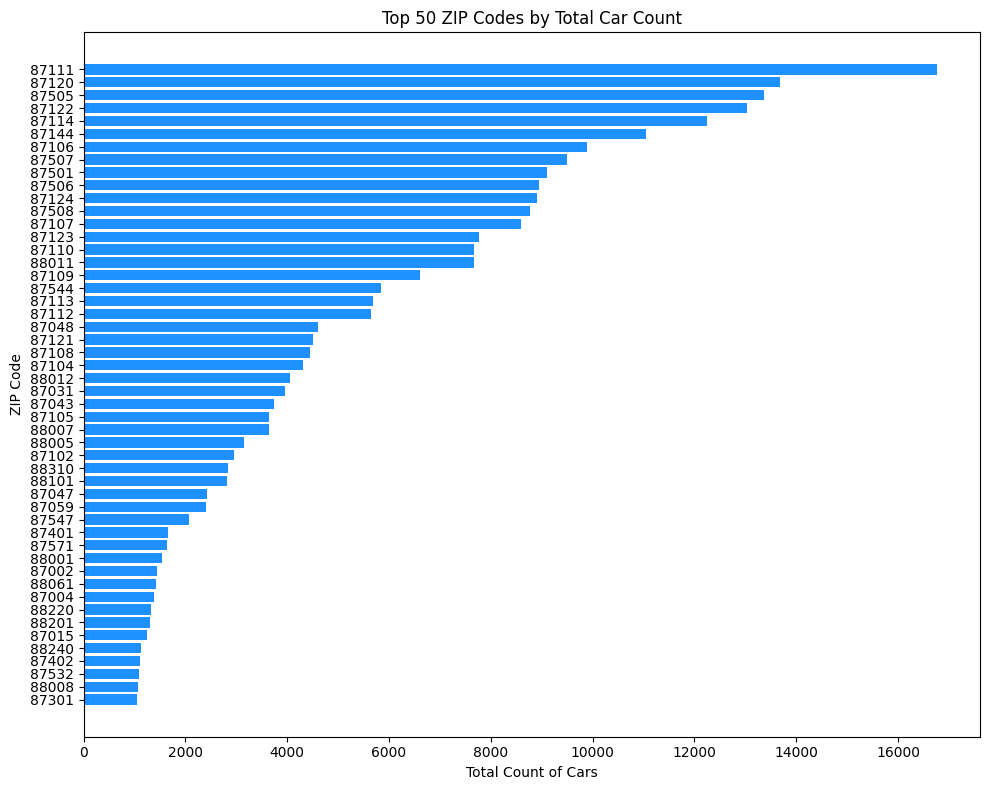

In [49]:
# Plot only the top 50 ZIP codes (since there are too many zip codes in this dataset)
N = 50
top_n_zipcodes = cars_per_zipcode.sort_values(by='Total Vehicles', ascending=False).head(N)
top_n_zipcodes_sorted = top_n_zipcodes.sort_values(by='Total Vehicles', ascending=True) # Sort for plotting order

plt.figure(figsize=(10, 8))
plt.barh(top_n_zipcodes_sorted['ZIP Code'], top_n_zipcodes_sorted['Total Vehicles'], color='dodgerblue')
plt.xlabel('Total Count of Cars')
plt.ylabel('ZIP Code')
plt.title(f'Top {N} ZIP Codes by Total Car Count')
plt.tight_layout()
plt.show()


## Data Processing

In [ ]:
# RMSPE
def rmspe(y_actual, y_pred):
  '''RMSPE - root mean squared percent error'''
  return np.sqrt(np.mean(np.square((y_actual - y_pred) / y_actual))) * 100


### Random Forest Regression

#### Cross-Validation


## Thought 1
- We can train the model by only including the zipcodes that have more than 2,000 EVs registered.
- We can discuss the logic of training the model later.    